In [1]:
import pandas as pd
import re
import nltk
import pickle
from time import sleep
import os
import numpy as np
import itertools
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch
from sklearn.utils.class_weight import compute_sample_weight
from GPUtil import showUtilization as gpu_usage

In [2]:
BASE_DIR = 'D:/MSC/NLP/NLP_ASS2/semeval-tweets/'
data_train  = pd.read_pickle(BASE_DIR + 'train_data.pkl')
data_test = pd.read_pickle(BASE_DIR + 'test_data.pkl')

In [3]:
EMBEDD_LEN = 100
vocab = {'PAD':np.random.normal(scale=0.6, size=(EMBEDD_LEN, ))}
vocab.update(pickle.load(open(BASE_DIR + 'LSTM_VOCAB_MAX.pkl', "rb")))

In [4]:
data_train['clean_text'] = data_train['clean_text'].apply(lambda x: [key for key, grp in itertools.groupby([ i if i in vocab else 'UNK' for i in x ])] )
data_test['clean_text'] = data_test['clean_text'].apply(lambda x: [key for key, grp in itertools.groupby([ i if i in vocab else 'UNK' for i in x ])] )

data_train['nm_all_tok']= data_train['clean_text'].apply(lambda x: len(x))

In [5]:
data_train['nm_all_tok'].quantile(0.99)

32.0

In [6]:
MIN_LENGTH = 1 #data_train['nm_all_tok'].quantile(0.01)
MAX_LENGTH = 33 #data_train['nm_all_tok'].quantile(0.99)
data_train = data_train[~(data_train['nm_all_tok'] < MIN_LENGTH) | (data_train['nm_all_tok'] > MAX_LENGTH)]
# data_test = data_test[~(data_test['nm_all_tok'] < MIN_LENGTH) | (data_test['nm_all_tok'] > MAX_LENGTH)]


vocab['UNK'] = np.random.normal(scale=0.6, size=(EMBEDD_LEN, ))
word_to_idx = dict(zip(vocab.keys(),range(len(vocab.keys()))))
weights_matrix = torch.from_numpy(np.vstack(list(vocab.values())))

data_train['clean_text'] = data_train['clean_text'].apply(lambda x: [ word_to_idx[item] for item in x ])
data_test['clean_text'] = data_test['clean_text'].apply(lambda x: [ word_to_idx[item] for item in x ])

In [7]:
binariser = LabelBinarizer()
train_y = binariser.fit_transform(data_train['sentiment'].values)
test_y = binariser.transform(data_test['sentiment'].values)

In [8]:
DATA_TRAIN = list(zip(list(data_train['clean_text'].values),train_y))
DATA_TEST = list(zip(list(data_test['clean_text'].values),test_y))
print(len(DATA_TRAIN))
print(len(DATA_TEST))

47026
3531


In [9]:
def custom_collate_fn(batch):
    x, y = zip(*batch)  
    x = list(map(lambda x: torch.tensor(x), x))
    lens = list(map(len, x))
    padded = pad_sequence(x, batch_first=True)
    y = torch.from_numpy(np.vstack(list(map(lambda x: torch.tensor(x), y))))
    return padded, y,lens

In [10]:
BATCH_SIZE = 2000
loader_train = DataLoader(DATA_TRAIN, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn,drop_last=True)
test_x,test_y,test_lengths = custom_collate_fn(DATA_TEST)

In [12]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

gpu_usage()

GPU is available
| ID | GPU | MEM |
------------------
|  0 |  1% |  2% |


In [13]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class ToyNN1(torch.nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers,output_size):
        super().__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True,dropout=0.3,bidirectional=True)
        self.dropout = torch.nn.Dropout(0.5)
        self.hidden_layer1 = torch.nn.Sequential(
            torch.nn.Linear(256, output_size),)
        self.hidden_layer = torch.nn.Sequential(
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, output_size))
        
        
    def forward(self, inp,lens):
        if next(self.parameters()).is_cuda:
            pad_embed = self.embedding(inp).to(device)
        else:
            pad_embed = self.embedding(inp)
        pad_embed_pack = pack_padded_sequence(pad_embed, lens, batch_first=True, enforce_sorted=False)
        seq, (ht, ct) = self.lstm(pad_embed_pack)
        out = self.dropout(torch.cat((ht[-1],ht[-2]), 1))
        out = self.hidden_layer1(out)
        return torch.nn.functional.softmax(out,dim=-1)
    
    
class ToyNN2(torch.nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers,output_size,train_on_gpu=False):
        super().__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_dim = hidden_size
        self.n_layers = num_layers
        self.gpu = train_on_gpu
        self.lstm = torch.nn.LSTM(embedding_dim, self.hidden_dim, self.n_layers, batch_first=True,dropout=0.2)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(self.hidden_dim, output_size)
        
    def forward(self, inp,lens,hidden_input):
        batch_size = inp.size(0)
        pad_embed = self.embedding(inp).to(device)
        lstm_out, hidden = self.lstm(pad_embed, hidden_input)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.nn.functional.softmax(out,dim=-1)
        sig_out = sig_out.view(batch_size,max(lens), -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        return sig_out,hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if (self.gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [14]:
model = ToyNN1(weights_matrix,128,2,3)
model.to(device)
print(model)
gpu_usage()

lr=0.001
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
clip = 5
epochs = 50

ToyNN1(
  (embedding): Embedding(5000, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=256, out_features=3, bias=True)
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)
| ID | GPU | MEM |
------------------
|  0 |  3% | 16% |


In [15]:
torch.cuda.empty_cache()
train_acces,train_losses,test_acces,test_losses = [],[],[],[]
for epoch in range(epochs):
    train_outputs,train_labels = [],[]
    train_acc = 0.0
    model.train()
    for inputs,labels,lengths in loader_train:
        sample_weight = torch.from_numpy(compute_sample_weight(class_weight='balanced',y=labels)).to(device)
        inputs, labels = inputs.to(device), labels.to(device)   
        model.zero_grad()
        output = model(inputs,lengths)
        loss = criterion(output.squeeze(), labels.float())
        loss = (loss * sample_weight).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_outputs.append(output.cpu().detach().numpy())
        train_labels.append(labels.cpu().detach().numpy())
        del inputs, labels, output, loss
        torch.cuda.empty_cache()
        
    with torch.no_grad():
        train_outputs = np.vstack(train_outputs)
        train_y = np.vstack(train_labels)
        train_loss = criterion(torch.from_numpy(train_outputs.squeeze()),torch.from_numpy(train_y.astype(float)) ).mean()
        train_losses.append(train_loss)
        train_acc = f1_score( np.argmax(train_y,axis=-1) , np.argmax(train_outputs,axis=-1) ,average='macro')
        train_acces.append(train_acc)

        test_outputs = model(test_x.to(device),test_lengths).cpu()
        test_loss = criterion(test_outputs.squeeze(), test_y.float()).mean()
        test_losses.append(test_loss)
        test_acc = f1_score( np.argmax(test_y,axis=-1) , torch.argmax(test_outputs,dim=-1) ,average='macro')
        test_acces.append(test_acc)


        print('''Epoch {epoch} Train Loss: {train_loss}, Test Loss: {test_loss}, Train Acc: {train_acc}, Test Acc: {test_acc}'''\
              .format(epoch=epoch,train_loss=train_loss,test_loss=test_loss,train_acc=train_acc,test_acc=test_acc))
        del test_outputs, test_loss,train_outputs, train_labels,train_loss
        torch.cuda.empty_cache()
        gpu_usage()
        print(25*'==')

Epoch 0 Train Loss: 1.1442606372392696, Test Loss: 1.0599970817565918, Train Acc: 0.23590635828458584, Test Acc: 0.34114682452261746
| ID | GPU | MEM |
------------------
|  0 | 75% | 22% |
Epoch 1 Train Loss: 1.0620851716774962, Test Loss: 1.0165778398513794, Train Acc: 0.41465414630361036, Test Acc: 0.5208610638289094
| ID | GPU | MEM |
------------------
|  0 | 56% | 22% |
Epoch 2 Train Loss: 1.0256423516066178, Test Loss: 0.9771782755851746, Train Acc: 0.5046273736200669, Test Acc: 0.5352990565225474
| ID | GPU | MEM |
------------------
|  0 | 70% | 22% |
Epoch 3 Train Loss: 1.0105097393328728, Test Loss: 0.9558832049369812, Train Acc: 0.5208094577845105, Test Acc: 0.5583432201964141
| ID | GPU | MEM |
------------------
|  0 | 76% | 22% |
Epoch 4 Train Loss: 0.9914127637147904, Test Loss: 0.9257593750953674, Train Acc: 0.5422387045708854, Test Acc: 0.5944438314384254
| ID | GPU | MEM |
------------------
|  0 | 54% | 22% |
Epoch 5 Train Loss: 0.9853935504970344, Test Loss: 0.9313

In [16]:
x,y,l = next(iter(loader_train))

In [22]:
out = model(x.to(device),l)

In [31]:
loss = criterion1(out.squeeze(), y.to(device).float())

In [32]:
loss.mean()

tensor(0.7369, device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
(loss * weight).mean()

tensor(0.7252, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

In [27]:
criterion1 = torch.nn.CrossEntropyLoss(reduction='none')

In [30]:
weight = torch.from_numpy(compute_sample_weight(class_weight='balanced',y=y)).to(device)

In [15]:
import matplotlib.pyplot as plt

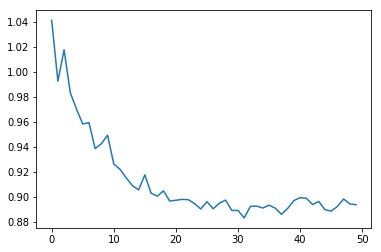

In [16]:
plt.plot(test_losses)

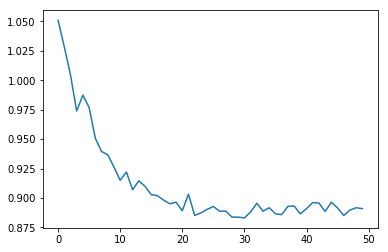

In [21]:
plt.plot(test_losses)

In [12]:
model = ToyNN2(weights_matrix,100,2,3,True)
model.to(device)
print(model)
gpu_usage()

lr=0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
clip = 5
epochs = 40

ToyNN2(
  (embedding): Embedding(5000, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
| ID | GPU | MEM |
------------------
|  0 |  3% | 16% |


In [13]:
torch.cuda.empty_cache()
train_acces,train_losses,test_acces,test_losses = [],[],[],[]
for epoch in range(epochs):
    train_outputs,train_labels = [],[]
    train_acc = 0.0
    model.train()
    h = model.init_hidden(BATCH_SIZE)
    for inputs,labels,lengths in loader_train:
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(inputs,lengths,h)
        torch.cuda.empty_cache()
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_outputs.append(output.cpu().detach().numpy())
        train_labels.append(labels.cpu().detach().numpy())
        del inputs, labels, output, loss
        torch.cuda.empty_cache()
        
    with torch.no_grad():
        train_outputs = np.vstack(train_outputs)
        train_y = np.vstack(train_labels)
        train_loss = criterion(torch.from_numpy(train_outputs.squeeze()),torch.from_numpy(train_y.astype(float)) )
        train_losses.append(train_loss)
        train_acc = f1_score( np.argmax(train_y,axis=-1) , np.argmax(train_outputs,axis=-1) ,average='macro')
        train_acces.append(train_acc)

        val_h = model.init_hidden(len(DATA_TEST))
        c = tuple([each.data for each in val_h])
        test_outputs,_ = model(test_x.to(device),test_lengths,val_h)
        test_outputs = test_outputs.cpu()
        test_loss = criterion(test_outputs.squeeze(), test_y.float())
        test_losses.append(test_loss)
        test_acc = f1_score( np.argmax(test_y,axis=-1) , torch.argmax(test_outputs,dim=-1) ,average='macro')
        test_acces.append(test_acc)


        print('''Epoch {epoch} Train Loss: {train_loss}, Test Loss: {test_loss}, Train Acc: {train_acc}, Test Acc: {test_acc}'''\
              .format(epoch=epoch,train_loss=train_loss,test_loss=test_loss,train_acc=train_acc,test_acc=test_acc))
        del test_outputs, test_loss,train_outputs, train_labels,train_loss
        torch.cuda.empty_cache()
        gpu_usage()
        print(25*'==')

Epoch 0 Train Loss: 1.0529532072621006, Test Loss: 1.0432411432266235, Train Acc: 0.21919591580366568, Test Acc: 0.22379144709371254
| ID | GPU | MEM |
------------------
|  0 | 73% | 19% |
Epoch 1 Train Loss: 1.045135930698405, Test Loss: 1.0488736629486084, Train Acc: 0.21740352867200272, Test Acc: 0.19963212313530623
| ID | GPU | MEM |
------------------
|  0 | 61% | 20% |
Epoch 2 Train Loss: 1.0442332244957646, Test Loss: 1.0434054136276245, Train Acc: 0.21107936707093974, Test Acc: 0.19913935782853356
| ID | GPU | MEM |
------------------
|  0 | 50% | 20% |
Epoch 3 Train Loss: 1.0439888608545385, Test Loss: 1.0425844192504883, Train Acc: 0.2101967646134921, Test Acc: 0.19963212313530623
| ID | GPU | MEM |
------------------
|  0 | 44% | 20% |
Epoch 4 Train Loss: 1.0435631383247272, Test Loss: 1.0384944677352905, Train Acc: 0.21107031208756089, Test Acc: 0.19957818726837537
| ID | GPU | MEM |
------------------
|  0 | 74% | 20% |
Epoch 5 Train Loss: 1.0392379034270522, Test Loss: 1

In [31]:
test_x.shape[0]

3531

In [ ]:
# embeddings_dict = {}
# with open(BASE_DIR + "glove.6B.100d.txt", 'r', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         token = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_dict[token] = vector

# from sklearn.feature_extraction.text import CountVectorizer
# count_vector = CountVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x)
# count_vector.fit(data_train['clean_text'])

# vocab = count_vector.vocabulary_

# min_list,max_list = [],[]
# while len(vocab) > 0:
#     min_word = min(vocab,key=vocab.get)
#     min_list.append(min_word)
#     vocab.pop(min_word)
#     if len(vocab) == 0:
#         break
#     max_word = max(vocab,key=vocab.get)
#     max_list.append(max_word)
#     vocab.pop(max_word)
    
# new_vocab = {}
# while len(new_vocab) != 4998:
#     word = max_list[-1]
#     vector = embeddings_dict.get(word)
#     if vector is None :
#         max_list.pop()
#     else:
#         new_vocab[word] = vector
#         max_list.pop()
#         if len(new_vocab) == 4998:
#             break
#     word = min_list[-1]
#     vector = embeddings_dict.get(word)
#     if vector is None:
#         min_list.pop()
#     else:
#         new_vocab[word] = vector
#         min_list.pop()
#         if len(new_vocab) == 4998:
#             break
            
# pickle.dump(new_vocab,open(BASE_DIR + 'LSTM_VOCAB.pkl', "wb"))

In [ ]:
# ## Contractions
# file = open(BASE_DIR + 'CONTRACTIONS.pkl', "rb")
# CONTRACTION_MAP = pickle.load(file)
# sleep(1)
# del file
# contraction = sorted(CONTRACTION_MAP, key=len, reverse=True)
# c_re = re.compile('(%s)' % '|'.join(contraction))
# def expandContractions(text, c_re=c_re):
#     def replace(match):
#         return CONTRACTION_MAP[match.group(0)]
#     return c_re.sub(replace, text.lower())

# ## Emojis Regex
# file = open(BASE_DIR + 'EMOJIS.pkl', "rb")
# EMOJIS = pickle.load(file)
# sleep(1)
# del file
# emojis = sorted(EMOJIS, key=len, reverse=True)
# pattern = '|'.join(re.escape(u) for u in emojis)
# regex = re.compile(pattern, re.U)

# ## Regex expression for Booster Increase and Decrease words
# B_INC = ['exceptionally', 'substantially', 'considerable', 'considerably', 'particularly', 'tremendously', 'unbelievably',\
#          'exceptional', 'absolutely', 'completely', 'enormously', 'especially', 'fabulously', 'incredible', 'incredibly',\
#          'remarkably', 'thoroughly', 'tremendous', 'amazingly', 'decidedly', 'extremely', 'intensely', 'unusually',\
#          'enormous', 'entirely', 'flipping', 'fracking', 'fricking', 'frigging', 'awfully', 'extreme', 'flippin',\
#          'frackin', 'frickin', 'friggin', 'fucking', 'fugging', 'greatly', 'majorly', 'totally', 'utterly', 'deeply',\
#          'effing', 'fuckin', 'fuggin', 'highly', 'hugely', 'purely', 'really', 'fully', 'hella', 'major', 'quite',\
#          'total', 'utter', 'more', 'most', 'uber', 'very', 'so']
# B_DEC = ['almost', 'barely', 'hardly', 'just enough', 'kind of', 'kinda', 'kindof', 'kind-of', 'less', 'little',\
#          'marginal', 'marginally', 'occasional', 'occasionally', 'partly', 'scarce', 'scarcely', 'slight', 'slightly',\
#          'somewhat', 'sort of', 'sorta', 'sortof', 'sort-of']
# pattern_binc = '|'.join(re.escape(u) for u in B_INC)
# pattern_bdec = '|'.join(re.escape(u) for u in B_DEC)

# ## Reading EXICON DICT 
# file = open(BASE_DIR + 'VADER_LEXICONS_SCORE.pkl', "rb")
# LEXICON_DICT = pickle.load(file)
# sleep(1)
# del file


# file = open(BASE_DIR + 'POSITIVE.pkl', "rb")
# POS_LIST = pickle.load(file)
# sleep(1)
# del file
# POS_LIST = sorted(POS_LIST, key=len, reverse=True)
# pattern_pos = '|'.join(re.escape(u) for u in POS_LIST)

# file = open(BASE_DIR + 'NEGATIVE.pkl', "rb")
# NEG_LIST = pickle.load(file)
# sleep(1)
# del file
# NEG_LIST = sorted(NEG_LIST, key=len, reverse=True)
# pattern_neg = '|'.join(re.escape(u) for u in NEG_LIST)

# file = open(BASE_DIR + 'BAD.pkl', "rb")
# BAD_LIST = pickle.load(file)
# sleep(1)
# del file
# BAD_LIST = sorted(BAD_LIST, key=len, reverse=True)
# pattern_bad = '|'.join(re.escape(u) for u in BAD_LIST)

# def return_tok_val(sentence):
#     pos_tok = []
#     neg_tok = []
#     tokens = twokenize.tokenizeRawTweetText(sentence)
#     ln_all_tokens = len(tokens)
#     for toke in tokens:
#         val = LEXICON_DICT.get(toke)
#         if val:
#             if val >0:
#                 pos_tok.append(val)
#             else:
#                 neg_tok.append(val)
    
#     return tokens,ln_all_tokens,len(pos_tok),len(neg_tok),sum(pos_tok),sum(neg_tok)

# def clean_data(data,col,re_inc_boostr,re_dec_boostr,re_pos,re_neg,re_bad):
#     dataframe = data.copy()
#     link_regex = re.compile(r'(?:ftp|https?|www|file)\.?:?[//|\\\\]?[\w\d:#@%/;$()~_?\+-=\\\&]+\.[\w\d:#@%/;$~_?\+-=\\\&]+')
#     dataframe = dataframe.assign(**dict(zip([col,'num_link'], zip(*dataframe['text'].apply(lambda x: re.subn(link_regex,'LINK',x) ) ))))
#     dataframe = dataframe.assign(**dict(zip([col,'num_usermention'], zip(*dataframe[col].apply(lambda x: re.subn(r'@[\w]*','USERMENTION',x)) ))))
#     dataframe = dataframe.assign(**dict(zip([col,'num_hashtag'], zip(*dataframe[col].apply(lambda x: re.subn(r'#[\w]*','HASHTAG',x) ) ))))
#     dataframe = dataframe.assign(**dict(zip([col,'num_emoji'], zip(*dataframe[col].apply(lambda x: re.subn(regex, lambda m: EMOJIS.get(m.group(), 'EMOJI') , x) )))))
#     dataframe[col] = dataframe[col].apply(lambda x : re.sub(r'(.)\1{2,}', r'\1',x)) # make looong as long
#     dataframe[col] = dataframe[col].apply(lambda x : expandContractions(x) ) # expand contracts
#     dataframe[col] = dataframe[col].str.lower()
#     dataframe['NUM_INC_BOOSTR'] = dataframe[col].apply(lambda x : len(re.findall(re_inc_boostr,x)) ) # Booster Increasing Words
#     dataframe['NUM_DEC_BOOSTR'] = dataframe[col].apply(lambda x : len(re.findall(re_dec_boostr,x)) ) # Booster Increasing Words
#     dataframe['NUM_POS_WORDS'] = dataframe[col].apply(lambda x : len(re.findall(re_pos,x)) ) # Number of Positive words
#     dataframe['NUM_NEG_WORDS'] = dataframe[col].apply(lambda x : len(re.findall(re_neg,x)) ) # Number of Positive words
#     dataframe['NUM_BAD_WORDS'] = dataframe[col].apply(lambda x : len(re.findall(re_bad,x)) ) # Number of Positive words
#     dataframe = dataframe.assign(**dict(zip([col,'num_exclaim'], zip(*dataframe[col].apply(lambda x: re.subn(r"[!]",'',x)  ) ))))  
#     dataframe = dataframe.assign(**dict(zip([col,'num_punct'], zip(*dataframe[col].apply(lambda x: re.subn(r"['\"“”‘’.?!…,:;]",'',x)  ) ))))  

#     dataframe = dataframe.assign(**dict(zip([col,'nm_all_tok','nm_pos_tok','nm_neg_tok','sm_pos_tok','sum_nrg_tok'], zip(*dataframe[col].apply(lambda x: return_tok_val(x) ) ))))
#     dataframe['lex_tok'] = dataframe['nm_pos_tok'] + dataframe['nm_neg_tok']
#     dataframe['total_lex_score'] = dataframe['sm_pos_tok'] + dataframe['sum_nrg_tok']
#     dataframe['r_sco/tok'] = dataframe['total_lex_score']/dataframe['lex_tok']
#     for col in dataframe.columns.difference(['clean_text','text','sentiment']):
#         dataframe[col] += abs(dataframe[col].min())
    
#     dataframe = dataframe.fillna(0)
    
#     return dataframe

# df_train = pd.read_csv(BASE_DIR + 'twitter-training-data.txt',sep='\t',names=['ID','sentiment','text']).drop('ID',axis=1)
# df_dev = pd.read_csv(BASE_DIR + 'twitter-dev-data.txt',sep='\t',names=['ID','sentiment','text']).drop('ID',axis=1)
# df_train = pd.concat([df_train,df_dev]).reset_index(drop=True)
# del df_dev
# df_test = pd.read_csv(BASE_DIR + 'twitter-test1.txt',sep='\t',names=['ID','sentiment','text']).drop('ID',axis=1)


# df_train['clean_text'] = df_train['text']
# df_test['clean_text'] = df_test['text']

# df_train = clean_data(df_train,'clean_text',pattern_binc,pattern_bdec,pattern_pos,pattern_neg,pattern_bad)
# df_test = clean_data(df_test,'clean_text',pattern_binc,pattern_bdec,pattern_pos,pattern_neg,pattern_bad)

# replace = {'positive': 0, 'negative': 1, 'neutral': 2}
# df_train['sentiment'] = df_train['sentiment'].replace(replace)
# df_test['sentiment'] = df_test['sentiment'].replace(replace)

# df_train.to_pickle(BASE_DIR + 'train_data.pkl')
# df_test.to_pickle(BASE_DIR + 'test_data.pkl')